# Tutorial for deepSpeech.pytorch

this jupyter notebooks is explaining how deepspeech.pytorch work.
I put every componento on this notebooks, so you can check each step from data preprocessing to model to training.

## What is deepspeech.pytorch ?
deepspeech.pytorch is an awesome implentation of Baidu's DeepSpeech 2 paper.

https://github.com/SeanNaren/deepspeech.pytorch

## Requirements
### Warp-CTC
you need Warp-CTC for loss function.
please follow the instruction at https://github.com/SeanNaren/deepspeech.pytorch to install Warp-CTC.  
```
git clone https://github.com/SeanNaren/warp-ctc.git
cd warp-ctc; mkdir build; cd build; cmake ..; make
export CUDA_HOME="/usr/local/cuda"
cd ../pytorch_binding && python setup.py install
```

### other dependancy:  
scipy, numpy, soundfile,  python-levenshtein, torch, torchelastic, wget, librosa, tqdm, matplotlib, sox, sklearn

I remove apex part so that you can test this code even with CPU.

In [1]:
# this is just a jupyter things
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import basic library
import json
import os
import random
import time

In [3]:
# import deep learning related
import torch
from warpctc_pytorch import CTCLoss

## Let's define modules 

### Define SpectrogramDataset, DSRandomSampler, AudioDataLoader
This is equivalent of ```from data.data_loader import SpectrogramDataset, DSRandomSampler, AudioDataLoader```

In [4]:
# pip install numba==0.48

In [5]:
import math
import os
from tempfile import NamedTemporaryFile
import librosa
import numpy as np
import scipy.signal
import soundfile as sf
import sox
import torch
from torch.utils.data import Dataset, Sampler, DataLoader

windows = {
    'hamming': scipy.signal.hamming,
    'hann': scipy.signal.hann,
    'blackman': scipy.signal.blackman,
    'bartlett': scipy.signal.bartlett
}

In [6]:
def augment_audio_with_sox(path, sample_rate, tempo, gain):
    """
    Changes tempo and gain of the recording with sox and loads it.
    """
    with NamedTemporaryFile(suffix=".wav") as augmented_file:
        augmented_filename = augmented_file.name
        sox_augment_params = ["tempo", "{:.3f}".format(tempo), "gain", "{:.3f}".format(gain)]
        sox_params = "sox \"{}\" -r {} -c 1 -b 16 -e si {} {} >/dev/null 2>&1".format(path, sample_rate,
                                                                                      augmented_filename,
                                                                                      " ".join(sox_augment_params))
        os.system(sox_params)
        y = load_audio(augmented_filename)
        return y


In [7]:
def load_randomly_augmented_audio(path, sample_rate=16000, tempo_range=(0.85, 1.15),
                                  gain_range=(-6, 8)):
    """
    Picks tempo and gain uniformly, applies it to the utterance by using sox utility.
    Returns the augmented utterance.
    """
    low_tempo, high_tempo = tempo_range
    tempo_value = np.random.uniform(low=low_tempo, high=high_tempo)
    low_gain, high_gain = gain_range
    gain_value = np.random.uniform(low=low_gain, high=high_gain)
    audio = augment_audio_with_sox(path=path, sample_rate=sample_rate,
                                   tempo=tempo_value, gain=gain_value)
    return audio

In [8]:

class AudioParser(object):
    def parse_transcript(self, transcript_path):
        """
        :param transcript_path: Path where transcript is stored from the manifest file
        :return: Transcript in training/testing format
        """
        raise NotImplementedError

    def parse_audio(self, audio_path):
        """
        :param audio_path: Path where audio is stored from the manifest file
        :return: Audio in training/testing format
        """
        raise NotImplementedError

In [9]:

class SpectrogramParser(AudioParser):
    def __init__(self, audio_conf, normalize=False, speed_volume_perturb=False, spec_augment=False):
        """
        Parses audio file into spectrogram with optional normalization and various augmentations
        :param audio_conf: Dictionary containing the sample rate, window and the window length/stride in seconds
        :param normalize(default False):  Apply standard mean and deviation normalization to audio tensor
        :param speed_volume_perturb(default False): Apply random tempo and gain perturbations
        :param spec_augment(default False): Apply simple spectral augmentation to mel spectograms
        """
        super(SpectrogramParser, self).__init__()
        self.window_stride = audio_conf['window_stride']
        self.window_size = audio_conf['window_size']
        self.sample_rate = audio_conf['sample_rate']
        # self.window = windows.get(audio_conf['window'], windows['hamming'])
        self.window = windows.get(audio_conf['window'], windows['hamming'])
        self.normalize = normalize
        self.speed_volume_perturb = speed_volume_perturb
        self.spec_augment = spec_augment
        self.noiseInjector = NoiseInjection(audio_conf['noise_dir'], self.sample_rate,
                                            audio_conf['noise_levels']) if audio_conf.get(
            'noise_dir') is not None else None
        self.noise_prob = audio_conf.get('noise_prob')

    def parse_audio(self, audio_path):
        if self.speed_volume_perturb:
            y = load_randomly_augmented_audio(audio_path, self.sample_rate)
        else:
            y = load_audio(audio_path)
        if self.noiseInjector:
            add_noise = np.random.binomial(1, self.noise_prob)
            if add_noise:
                y = self.noiseInjector.inject_noise(y)
        n_fft = int(self.sample_rate * self.window_size)
        win_length = n_fft
        hop_length = int(self.sample_rate * self.window_stride)
        # STFT
        D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length,
                         win_length=win_length, window=self.window)
        spect, phase = librosa.magphase(D)
        # S = log(S+1)
        spect = np.log1p(spect)
        spect = torch.FloatTensor(spect)
        if self.normalize:
            mean = spect.mean()
            std = spect.std()
            spect.add_(-mean)
            spect.div_(std)

        if self.spec_augment:
            spect = spec_augment(spect)

        return spect

    def parse_transcript(self, transcript_path):
        raise NotImplementedError

In [10]:
class SpectrogramDataset(Dataset, SpectrogramParser):
    def __init__(self, audio_conf, manifest_filepath, labels, normalize=False, speed_volume_perturb=False,
                 spec_augment=False):
        """
        Dataset that loads tensors via a csv containing file paths to audio files and transcripts separated by
        a comma. Each new line is a different sample. Example below:

        /path/to/audio.wav,/path/to/audio.txt
        ...

        :param audio_conf: Dictionary containing the sample rate, window and the window length/stride in seconds
        :param manifest_filepath: Path to manifest csv as describe above
        :param labels: String containing all the possible characters to map to
        :param normalize: Apply standard mean and deviation normalization to audio tensor
        :param speed_volume_perturb(default False): Apply random tempo and gain perturbations
        :param spec_augment(default False): Apply simple spectral augmentation to mel spectograms
        """
        with open(manifest_filepath) as f:
            ids = f.readlines()
        ids = [x.strip().split(',') for x in ids]
        self.ids = ids
        self.size = len(ids)
        self.labels_map = dict([(labels[i], i) for i in range(len(labels))])
        super(SpectrogramDataset, self).__init__(audio_conf, normalize, speed_volume_perturb, spec_augment)

    def __getitem__(self, index):
        sample = self.ids[index]
        audio_path, transcript_path = sample[0], sample[1]
        spect = self.parse_audio(audio_path)
        transcript = self.parse_transcript(transcript_path)
        return spect, transcript

    def parse_transcript(self, transcript_path):
        with open(transcript_path, 'r', encoding='utf8') as transcript_file:
            transcript = transcript_file.read().replace('\n', '')
        transcript = list(filter(None, [self.labels_map.get(x) for x in list(transcript)]))
        return transcript

    def __len__(self):
        return self.size


In [11]:
class DSRandomSampler(Sampler):
    """
    Implementation of a Random Sampler for sampling the dataset.
    Added to ensure we reset the start index when an epoch is finished.
    This is essential since we support saving/loading state during an epoch.
    """

    def __init__(self, dataset, batch_size=1, start_index=0):
        super().__init__(data_source=dataset)

        self.dataset = dataset
        self.start_index = start_index
        self.batch_size = batch_size
        ids = list(range(len(self.dataset)))
        self.bins = [ids[i:i + self.batch_size] for i in range(0, len(ids), self.batch_size)]

    def __iter__(self):
        # deterministically shuffle based on epoch
        g = torch.Generator()
        g.manual_seed(self.epoch)
        indices = (
            torch.randperm(len(self.bins) - self.start_index, generator=g)
                .add(self.start_index)
                .tolist()
        )
        for x in indices:
            batch_ids = self.bins[x]
            np.random.shuffle(batch_ids)
            yield batch_ids

    def __len__(self):
        return len(self.bins) - self.start_index

    def set_epoch(self, epoch):
        self.epoch = epoch

    def reset_training_step(self, training_step):
        self.start_index = training_step

In [12]:
def _collate_fn(batch):

    def func(p):
        return p[0].size(1)

    batch = sorted(batch, key=lambda sample: sample[0].size(1), reverse=True)
    longest_sample = max(batch, key=func)[0]
    freq_size = longest_sample.size(0)
    minibatch_size = len(batch)
    max_seqlength = longest_sample.size(1)
    inputs = torch.zeros(minibatch_size, 1, freq_size, max_seqlength)
    input_percentages = torch.FloatTensor(minibatch_size)
    target_sizes = torch.IntTensor(minibatch_size)
    targets = []
    # audio_paths = []
    for x in range(minibatch_size):
        sample = batch[x]
        tensor = sample[0]
        target = sample[1]
        seq_length = tensor.size(1)
        inputs[x][0].narrow(1, 0, seq_length).copy_(tensor)
        input_percentages[x] = seq_length / float(max_seqlength)
        target_sizes[x] = len(target)
        targets.extend(target)
        # audio_path = sample[2]
        # audio_paths.append(audio_path)
    targets = torch.IntTensor(targets)
    return inputs, targets, input_percentages, target_sizes

In [13]:

class AudioDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        """
        Creates a data loader for AudioDatasets.
        """
        super(AudioDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = _collate_fn

### define GreedyDecoder, decoder
this is equivalent of ```from decoder import GreedyDecoder```

You can use *BeamDecoder*. But you need to install ctcdecode at that case.

In [14]:
import Levenshtein as Lev
import torch
from six.moves import xrange

In [15]:
class Decoder(object):
    """
    Basic decoder class from which all other decoders inherit. Implements several
    helper functions. Subclasses should implement the decode() method.

    Arguments:
        labels (list): mapping from integers to characters.
        blank_index (int, optional): index for the blank '_' character. Defaults to 0.
        space_index (int, optional): index for the space ' ' character. Defaults to 28.
    """

    def __init__(self, labels, blank_index=0):
        self.labels = labels
        self.int_to_char = dict([(i, c) for (i, c) in enumerate(labels)])
        self.blank_index = blank_index
        space_index = len(labels)  # To prevent errors in decode, we add an out of bounds index for the space
        if ' ' in labels:
            space_index = labels.index(' ')
        self.space_index = space_index

    def wer(self, s1, s2):
        """
        Computes the Word Error Rate, defined as the edit distance between the
        two provided sentences after tokenizing to words.
        Arguments:
            s1 (string): space-separated sentence
            s2 (string): space-separated sentence
        """

        # build mapping of words to integers
        b = set(s1.split() + s2.split())
        word2char = dict(zip(b, range(len(b))))

        # map the words to a char array (Levenshtein packages only accepts
        # strings)
        w1 = [chr(word2char[w]) for w in s1.split()]
        w2 = [chr(word2char[w]) for w in s2.split()]

        return Lev.distance(''.join(w1), ''.join(w2))

    def cer(self, s1, s2):
        """
        Computes the Character Error Rate, defined as the edit distance.

        Arguments:
            s1 (string): space-separated sentence
            s2 (string): space-separated sentence
        """
        s1, s2, = s1.replace(' ', ''), s2.replace(' ', '')
        return Lev.distance(s1, s2)

    def decode(self, probs, sizes=None):
        """
        Given a matrix of character probabilities, returns the decoder's
        best guess of the transcription

        Arguments:
            probs: Tensor of character probabilities, where probs[c,t]
                            is the probability of character c at time t
            sizes(optional): Size of each sequence in the mini-batch
        Returns:
            string: sequence of the model's best guess for the transcription
        """
        raise NotImplementedError


In [16]:
class GreedyDecoder(Decoder):
    def __init__(self, labels, blank_index=0):
        super(GreedyDecoder, self).__init__(labels, blank_index)

    def convert_to_strings(self, sequences, sizes=None, remove_repetitions=False, return_offsets=False):
        """Given a list of numeric sequences, returns the corresponding strings"""
        strings = []
        offsets = [] if return_offsets else None
        for x in xrange(len(sequences)):
            seq_len = sizes[x] if sizes is not None else len(sequences[x])
            string, string_offsets = self.process_string(sequences[x], seq_len, remove_repetitions)
            strings.append([string])  # We only return one path
            if return_offsets:
                offsets.append([string_offsets])
        if return_offsets:
            return strings, offsets
        else:
            return strings

    def process_string(self, sequence, size, remove_repetitions=False):
        string = ''
        offsets = []
        for i in range(size):
            char = self.int_to_char[sequence[i].item()]
            if char != self.int_to_char[self.blank_index]:
                # if this char is a repetition and remove_repetitions=true, then skip
                if remove_repetitions and i != 0 and char == self.int_to_char[sequence[i - 1].item()]:
                    pass
                elif char == self.labels[self.space_index]:
                    string += ' '
                    offsets.append(i)
                else:
                    string = string + char
                    offsets.append(i)
        return string, torch.tensor(offsets, dtype=torch.int)

    def decode(self, probs, sizes=None):
        """
        Returns the argmax decoding given the probability matrix. Removes
        repeated elements in the sequence, as well as blanks.

        Arguments:
            probs: Tensor of character probabilities from the network. Expected shape of batch x seq_length x output_dim
            sizes(optional): Size of each sequence in the mini-batch
        Returns:
            strings: sequences of the model's best guess for the transcription on inputs
            offsets: time step per character predicted
        """
        _, max_probs = torch.max(probs, 2)
        strings, offsets = self.convert_to_strings(max_probs.view(max_probs.size(0), max_probs.size(1)), sizes,
                                                   remove_repetitions=True, return_offsets=True)
        return strings, offsets


### Define DeepSpeech, and supported_rnns
This is equivalent of ```from model import DeepSpeech, supported_rnns```

In [17]:
import math
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F

In [18]:
class InferenceBatchSoftmax(nn.Module):
    def forward(self, input_):
        if not self.training:
            return F.softmax(input_, dim=-1)
        else:
            return input_


In [19]:
class BatchRNN(nn.Module):
    def __init__(self, input_size, hidden_size, rnn_type=nn.LSTM, bidirectional=False, batch_norm=True):
        super(BatchRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.batch_norm = SequenceWise(nn.BatchNorm1d(input_size)) if batch_norm else None
        self.rnn = rnn_type(input_size=input_size, hidden_size=hidden_size,
                            bidirectional=bidirectional, bias=True)
        self.num_directions = 2 if bidirectional else 1

    def flatten_parameters(self):
        self.rnn.flatten_parameters()

    def forward(self, x, output_lengths):
        if self.batch_norm is not None:
            x = self.batch_norm(x)
        x = nn.utils.rnn.pack_padded_sequence(x, output_lengths)
        x, h = self.rnn(x)
        x, _ = nn.utils.rnn.pad_packed_sequence(x)
        if self.bidirectional:
            x = x.view(x.size(0), x.size(1), 2, -1).sum(2).view(x.size(0), x.size(1), -1)  # (TxNxH*2) -> (TxNxH) by sum
        return x


In [20]:

class SequenceWise(nn.Module):
    def __init__(self, module):
        """
        Collapses input of dim T*N*H to (T*N)*H, and applies to a module.
        Allows handling of variable sequence lengths and minibatch sizes.
        :param module: Module to apply input to.
        """
        super(SequenceWise, self).__init__()
        self.module = module

    def forward(self, x):
        t, n = x.size(0), x.size(1)
        x = x.view(t * n, -1)
        x = self.module(x)
        x = x.view(t, n, -1)
        return x

    def __repr__(self):
        tmpstr = self.__class__.__name__ + ' (\n'
        tmpstr += self.module.__repr__()
        tmpstr += ')'
        return tmpstr

In [21]:
class MaskConv(nn.Module):
    def __init__(self, seq_module):
        """
        Adds padding to the output of the module based on the given lengths. This is to ensure that the
        results of the model do not change when batch sizes change during inference.
        Input needs to be in the shape of (BxCxDxT)
        :param seq_module: The sequential module containing the conv stack.
        """
        super(MaskConv, self).__init__()
        self.seq_module = seq_module

    def forward(self, x, lengths):
        """
        :param x: The input of size BxCxDxT
        :param lengths: The actual length of each sequence in the batch
        :return: Masked output from the module
        """
        for module in self.seq_module:
            x = module(x)
            mask = torch.BoolTensor(x.size()).fill_(0)
            if x.is_cuda:
                mask = mask.cuda()
            for i, length in enumerate(lengths):
                length = length.item()
                if (mask[i].size(2) - length) > 0:
                    mask[i].narrow(2, length, mask[i].size(2) - length).fill_(1)
            x = x.masked_fill(mask, 0)
        return x, lengths

In [22]:
class DeepSpeech(nn.Module):
    def __init__(self, rnn_type, labels, rnn_hidden_size, nb_layers, audio_conf,
                 bidirectional, context=20):
        super(DeepSpeech, self).__init__()

        self.hidden_size = rnn_hidden_size
        self.hidden_layers = nb_layers
        self.rnn_type = rnn_type
        self.audio_conf = audio_conf
        self.labels = labels
        self.bidirectional = bidirectional

        sample_rate = self.audio_conf["sample_rate"]
        window_size = self.audio_conf["window_size"]
        num_classes = len(self.labels)

        self.conv = MaskConv(nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(20, 5)),
            nn.BatchNorm2d(32),
            nn.Hardtanh(0, 20, inplace=True),
            nn.Conv2d(32, 32, kernel_size=(21, 11), stride=(2, 1), padding=(10, 5)),
            nn.BatchNorm2d(32),
            nn.Hardtanh(0, 20, inplace=True)
        ))
        # Based on above convolutions and spectrogram size using conv formula (W - F + 2P)/ S+1
        rnn_input_size = int(math.floor((sample_rate * window_size) / 2) + 1)
        rnn_input_size = int(math.floor(rnn_input_size + 2 * 20 - 41) / 2 + 1)
        rnn_input_size = int(math.floor(rnn_input_size + 2 * 10 - 21) / 2 + 1)
        rnn_input_size *= 32

        rnns = []
        rnn = BatchRNN(input_size=rnn_input_size, hidden_size=rnn_hidden_size, rnn_type=rnn_type,
                       bidirectional=bidirectional, batch_norm=False)
        rnns.append(('0', rnn))
        for x in range(nb_layers - 1):
            rnn = BatchRNN(input_size=rnn_hidden_size, hidden_size=rnn_hidden_size, rnn_type=rnn_type,
                           bidirectional=bidirectional)
            rnns.append(('%d' % (x + 1), rnn))
        self.rnns = nn.Sequential(OrderedDict(rnns))
        self.lookahead = nn.Sequential(
            # consider adding batch norm?
            Lookahead(rnn_hidden_size, context=context),
            nn.Hardtanh(0, 20, inplace=True)
        ) if not bidirectional else None

        fully_connected = nn.Sequential(
            nn.BatchNorm1d(rnn_hidden_size),
            nn.Linear(rnn_hidden_size, num_classes, bias=False)
        )
        self.fc = nn.Sequential(
            SequenceWise(fully_connected),
        )
        self.inference_softmax = InferenceBatchSoftmax()

    def forward(self, x, lengths):
        lengths = lengths.cpu().int()
        output_lengths = self.get_seq_lens(lengths)
        x, _ = self.conv(x, output_lengths)

        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # Collapse feature dimension
        x = x.transpose(1, 2).transpose(0, 1).contiguous()  # TxNxH

        for rnn in self.rnns:
            x = rnn(x, output_lengths)

        if not self.bidirectional:  # no need for lookahead layer in bidirectional
            x = self.lookahead(x)

        x = self.fc(x)
        x = x.transpose(0, 1)
        # identity in training mode, softmax in eval mode
        x = self.inference_softmax(x)
        return x, output_lengths

    def get_seq_lens(self, input_length):
        """
        Given a 1D Tensor or Variable containing integer sequence lengths, return a 1D tensor or variable
        containing the size sequences that will be output by the network.
        :param input_length: 1D Tensor
        :return: 1D Tensor scaled by model
        """
        seq_len = input_length
        for m in self.conv.modules():
            if type(m) == nn.modules.conv.Conv2d:
                seq_len = ((seq_len + 2 * m.padding[1] - m.dilation[1] * (m.kernel_size[1] - 1) - 1) / m.stride[1] + 1)
        return seq_len.int()

    @classmethod
    def load_model(cls, path):
        package = torch.load(path, map_location=lambda storage, loc: storage)
        model = DeepSpeech.load_model_package(package)
        return model

    @classmethod
    def load_model_package(cls, package):
        model = cls(rnn_hidden_size=package['hidden_size'],
                    nb_layers=package['hidden_layers'],
                    labels=package['labels'],
                    audio_conf=package['audio_conf'],
                    rnn_type=supported_rnns[package['rnn_type']],
                    bidirectional=package.get('bidirectional', True))
        model.load_state_dict(package['state_dict'])
        return model

    def serialize_state(self):
        return {
            'hidden_size': self.hidden_size,
            'hidden_layers': self.hidden_layers,
            'rnn_type': supported_rnns_inv.get(self.rnn_type, self.rnn_type.__name__.lower()),
            'audio_conf': self.audio_conf,
            'labels': self.labels,
            'state_dict': self.state_dict(),
            'bidirectional': self.bidirectional,
        }

    @staticmethod
    def get_param_size(model):
        params = 0
        for p in model.parameters():
            tmp = 1
            for x in p.size():
                tmp *= x
            params += tmp
        return params


In [23]:
supported_rnns = {
    'lstm': nn.LSTM,
    'rnn': nn.RNN,
    'gru': nn.GRU
}
supported_rnns_inv = dict((v, k) for k, v in supported_rnns.items())

### Define TrainingState
this is equivalent of ```from state import TrainingState```

In [24]:
import torch

In [25]:
def remove_parallel_wrapper(model):
    """
    Return the model or extract the model out of the parallel wrapper
    :param model: The training model
    :return: The model without parallel wrapper
    """
    # Take care of distributed/data-parallel wrapper
    model_no_wrapper = model.module if hasattr(model, "module") else model
    return model_no_wrapper

In [26]:
class ResultState:
    def __init__(self,
                 loss_results,
                 wer_results,
                 cer_results):
        self.loss_results = loss_results
        self.wer_results = wer_results
        self.cer_results = cer_results

    def add_results(self,
                    epoch,
                    loss_result,
                    wer_result,
                    cer_result):
        self.loss_results[epoch] = loss_result
        self.wer_results[epoch] = wer_result
        self.cer_results[epoch] = cer_result

    def serialize_state(self):
        return {
            'loss_results': self.loss_results,
            'wer_results': self.wer_results,
            'cer_results': self.cer_results
        }

In [27]:
class TrainingState:
    def __init__(self,
                 model,
                 result_state=None,
                 optim_state=None,
                 amp_state=None,
                 best_wer=None,
                 avg_loss=0,
                 epoch=0,
                 training_step=0):
        """
        Wraps around training model and states for saving/loading convenience.
        For backwards compatibility there are more states being saved than necessary.
        """
        self.model = model
        self.result_state = result_state
        self.optim_state = optim_state
        self.amp_state = amp_state
        self.best_wer = best_wer
        self.avg_loss = avg_loss
        self.epoch = epoch
        self.training_step = training_step

    def track_optim_state(self, optimizer):
        self.optim_state = optimizer.state_dict()

    def track_amp_state(self, amp):
        self.amp_state = amp.state_dict()

    def init_results_tracking(self, epochs):
        self.result_state = ResultState(loss_results=torch.IntTensor(epochs),
                                        wer_results=torch.IntTensor(epochs),
                                        cer_results=torch.IntTensor(epochs))

    def add_results(self,
                    epoch,
                    loss_result,
                    wer_result,
                    cer_result):
        self.result_state.add_results(epoch=epoch,
                                      loss_result=loss_result,
                                      wer_result=wer_result,
                                      cer_result=cer_result)

    def init_finetune_states(self, epochs):
        """
        Resets the training environment, but keeps model specific states in tact.
        This is when fine-tuning a model on another dataset where training is to be reset but the model
        weights are to be loaded
        :param epochs: Number of epochs fine-tuning.
        """
        self.init_results_tracking(epochs)
        self._reset_amp_state()
        self._reset_optim_state()
        self._reset_epoch()
        self.reset_training_step()
        self._reset_best_wer()

    def serialize_state(self, epoch, iteration):
        model = remove_parallel_wrapper(self.model)
        model_dict = model.serialize_state()
        training_dict = self._serialize_training_state(epoch=epoch,
                                                       iteration=iteration)
        results_dict = self.result_state.serialize_state()
        # Ensure flat structure for backwards compatibility
        state_dict = {**model_dict, **training_dict, **results_dict}  # Combine dicts
        return state_dict

    def _serialize_training_state(self, epoch, iteration):
        return {
            'optim_dict': self.optim_state,
            'amp': self.amp_state,
            'avg_loss': self.avg_loss,
            'best_wer': self.best_wer,
            'epoch': epoch + 1,  # increment for readability
            'iteration': iteration,
        }

    @classmethod
    def load_state(cls, state_path):
        print("Loading state from model %s" % state_path)
        state = torch.load(state_path, map_location=lambda storage, loc: storage)
        model = DeepSpeech.load_model_package(state)
        optim_state = state['optim_dict']
        amp_state = state['amp']
        epoch = int(state.get('epoch', 1)) - 1  # Index start at 0 for training
        training_step = state.get('iteration', None)
        if training_step is None:
            epoch += 1  # We saved model after epoch finished, start at the next epoch.
            training_step = 0
        else:
            training_step += 1
        avg_loss = int(state.get('avg_loss', 0))
        loss_results = state['loss_results']
        cer_results = state['cer_results']
        wer_results = state['wer_results']
        best_wer = state.get('best_wer')

        result_state = ResultState(loss_results=loss_results,
                                   cer_results=cer_results,
                                   wer_results=wer_results)
        return cls(optim_state=optim_state,
                   amp_state=amp_state,
                   model=model,
                   result_state=result_state,
                   best_wer=best_wer,
                   avg_loss=avg_loss,
                   epoch=epoch,
                   training_step=training_step)

    def set_epoch(self, epoch):
        self.epoch = epoch

    def set_best_wer(self, wer):
        self.best_wer = wer

    def set_training_step(self, training_step):
        self.training_step = training_step

    def reset_training_step(self):
        self.training_step = 0

    def reset_avg_loss(self):
        self.avg_loss = 0

    def _reset_amp_state(self):
        self.amp_state = None

    def _reset_optim_state(self):
        self.optim_state = None

    def _reset_epoch(self):
        self.epoch = 0

    def _reset_best_wer(self):
        self.best_wer = None


### Define evaluate
this is equivalent of ```from test import evaluate```

In [28]:
import torch
from tqdm import tqdm

In [29]:
def evaluate(test_loader, device, model, decoder, target_decoder, save_output=None, verbose=False, half=False):
    model.eval()
    total_cer, total_wer, num_tokens, num_chars = 0, 0, 0, 0
    output_data = []
    for i, (data) in tqdm(enumerate(test_loader), total=len(test_loader)):
        
        inputs, targets, input_percentages, target_sizes = data

        input_sizes = input_percentages.mul_(int(inputs.size(3))).int()
        inputs = inputs.to(device)
        if half:
            inputs = inputs.half()
        # unflatten targets
        split_targets = []
        offset = 0
        for size in target_sizes:
            split_targets.append(targets[offset:offset + size])
            offset += size

        out, output_sizes = model(inputs, input_sizes)

        decoded_output, _ = decoder.decode(out, output_sizes)
        target_strings = target_decoder.convert_to_strings(split_targets)

        if save_output is not None:
            # add output to data array, and continue
            output_data.append((out.cpu(), output_sizes, target_strings))
        for x in range(len(target_strings)):
            transcript, reference = decoded_output[x][0], target_strings[x][0]
            wer_inst = decoder.wer(transcript, reference)
            cer_inst = decoder.cer(transcript, reference)
            total_wer += wer_inst
            total_cer += cer_inst
            num_tokens += len(reference.split())
            num_chars += len(reference.replace(' ', ''))
            if verbose:
                print("Ref:", reference.lower())
                print("Hyp:", transcript.lower())
                print("WER:", float(wer_inst) / len(reference.split()),
                      "CER:", float(cer_inst) / len(reference.replace(' ', '')), "\n")
    wer = float(total_wer) / num_tokens
    cer = float(total_cer) / num_chars
    return wer * 100, cer * 100, output_data

### Define check_loss, CheckpointHandler
this is equivalent of ```from utils import check_loss, CheckpointHandler```

In [30]:
import os
from pathlib import Path
import torch

In [31]:
def check_loss(loss, loss_value):
    """
    Check that warp-ctc loss is valid and will not break training
    :return: Return if loss is valid, and the error in case it is not
    """
    loss_valid = True
    error = ''
    if loss_value == float("inf") or loss_value == float("-inf"):
        loss_valid = False
        error = "WARNING: received an inf loss"
    elif torch.isnan(loss).sum() > 0:
        loss_valid = False
        error = 'WARNING: received a nan loss, setting loss value to 0'
    elif loss_value < 0:
        loss_valid = False
        error = "WARNING: received a negative loss"
    return loss_valid, error

In [32]:
class CheckpointHandler:
    def __init__(self,
                 save_folder: str,
                 best_val_model_name: str,
                 checkpoint_per_iteration: int,
                 save_n_recent_models: int):
        self.save_folder = Path(save_folder)
        self.save_folder.mkdir(parents=True, exist_ok=True)  # Ensure save folder exists
        self.checkpoint_prefix = 'deepspeech_checkpoint_'  # TODO do we want to expose this?
        self.checkpoint_prefix_path = self.save_folder / self.checkpoint_prefix
        self.best_val_path = self.save_folder / best_val_model_name
        self.checkpoint_per_iteration = checkpoint_per_iteration
        self.save_n_recent_models = save_n_recent_models

    def find_latest_checkpoint(self):
        """
        Finds the latest checkpoint in a folder based on the timestamp of the file.
        If there are no checkpoints, returns None.
        :return: The latest checkpoint path, or None if no checkpoints are found.
        """
        paths = list(self.save_folder.rglob(self.checkpoint_prefix + '*'))
        if paths:
            paths.sort(key=os.path.getctime)
            latest_checkpoint_path = paths[-1]
            return latest_checkpoint_path
        else:
            return None

    def check_and_delete_oldest_checkpoint(self):
        paths = list(self.save_folder.rglob(self.checkpoint_prefix + '*'))
        if paths and len(paths) >= self.save_n_recent_models:
            paths.sort(key=os.path.getctime)
            print("Deleting old checkpoint %s" % str(paths[0]))
            os.remove(paths[0])

    def save_checkpoint_model(self, epoch, state, i=None):
        if self.save_n_recent_models > 0:
            self.check_and_delete_oldest_checkpoint()
        model_path = self._create_checkpoint_path(epoch=epoch,
                                                  i=i)
        print("Saving checkpoint model to %s" % model_path)
        torch.save(obj=state.serialize_state(epoch=epoch,
                                             iteration=i),
                   f=model_path)

    def save_iter_checkpoint_model(self, epoch, state, i):
        if self.checkpoint_per_iteration > 0 and i > 0 and (i + 1) % self.checkpoint_per_iteration == 0:
            self.save_checkpoint_model(epoch=epoch,
                                       state=state,
                                       i=i)

    def save_best_model(self, epoch, state):
        print("Found better validated model, saving to %s" % self.best_val_path)
        torch.save(obj=state.serialize_state(epoch=epoch,
                                             iteration=None),
                   f=self.best_val_path)

    def _create_checkpoint_path(self, epoch, i=None):
        """
        Creates path to save checkpoint.
        We automatically iterate the epoch and iteration for readibility.
        :param epoch: The epoch (index starts at 0).
        :param i: The iteration (index starts at 0).
        :return: The path to save the model
        """
        if i:
            checkpoint_path = str(self.checkpoint_prefix_path) + 'epoch_%d_iter_%d.pth' % (epoch + 1, i + 1)
        else:
            checkpoint_path = str(self.checkpoint_prefix_path) + 'epoch_%d.pth' % (epoch + 1)
        return checkpoint_path

## Finally We're ready to start

### Prepare datasets
we use an4 audio dataset, which is relatively small and easy to experiment  
http://www.speech.cs.cmu.edu/databases/an4/

Input is wav file  
Outout is text file which contains text of course.

In [33]:
import os
import io
import shutil
import tarfile

from sklearn.model_selection import train_test_split
import wget

# from data.utils import create_manifest
import fnmatch
import io
import os
import subprocess
from tqdm import tqdm

In [34]:
def create_manifest(data_path, output_path, min_duration=None, max_duration=None):
    file_paths = [os.path.join(dirpath, f)
                  for dirpath, dirnames, files in os.walk(data_path)
                  for f in fnmatch.filter(files, '*.wav')]


    # print("file_paths: ", file_paths)

    file_paths = order_and_prune_files(file_paths, min_duration, max_duration)
    with io.FileIO(output_path, "w") as file:
        for wav_path in tqdm(file_paths, total=len(file_paths)):
            transcript_path = wav_path.replace('/wav/', '/txt/').replace('.wav', '.txt')
            sample = os.path.abspath(wav_path) + ',' + os.path.abspath(transcript_path) + '\n'
            file.write(sample.encode('utf-8'))
    print('\n')
    
def order_and_prune_files(file_paths, min_duration, max_duration):
    print("Sorting manifests...")
    duration_file_paths = [(path, float(subprocess.check_output(
        ['soxi -D \"%s\"' % path.strip()], shell=True))) for path in file_paths]
    if min_duration and max_duration:
        print("Pruning manifests between %d and %d seconds" % (min_duration, max_duration))
        duration_file_paths = [(path, duration) for path, duration in duration_file_paths if
                               min_duration <= duration <= max_duration]

    def func(element):
        return element[1]

    duration_file_paths.sort(key=func)
    return [x[0] for x in duration_file_paths]  # Remove durations

In [35]:
def _format_test_data(root_path):
    wav_path = root_path + 'wav/'
    file_ids_path = root_path + 'etc/an4_test.fileids'
    transcripts_path = root_path + 'etc/an4_test.transcription'
    root_wav_path = wav_path + 'an4test_clstk'

    _convert_audio_to_wav(root_wav_path)
    file_ids, transcripts = _retrieve_file_ids_and_transcripts(file_ids_path, transcripts_path)

    _save_wav_transcripts(data_type='test',
                          file_ids=file_ids,
                          transcripts=transcripts,
                          wav_dir=wav_path)


def _process_transcript(transcript):
    """
    Removes tags found in AN4.
    """
    extracted_transcript = transcript.split('(')[0].strip("<s>").split('<')[0].strip().upper()
    return extracted_transcript

def _save_files(file_ids, transcripts, wav_dir, new_wav_dir, new_transcript_dir):
    for file_id, transcript in zip(file_ids, transcripts):
        path = wav_dir + file_id.strip() + '.wav'
        filename = path.split('/')[-1]
        extracted_transcript = _process_transcript(transcript)
        new_path = new_wav_dir + filename
        text_path = new_transcript_dir + filename.replace('.wav', '.txt')
        with io.FileIO(text_path, "w") as file:
            file.write(extracted_transcript.encode('utf-8'))
        current_path = os.path.abspath(path)
        os.rename(current_path, new_path)


def _save_wav_transcripts(data_type, file_ids, transcripts, wav_dir):
    
    target_dir = './data/an4_dataset/'
    
    data_path = target_dir + data_type + '/an4/'
    new_transcript_dir = data_path + '/txt/'
    new_wav_dir = data_path + '/wav/'

    os.makedirs(new_transcript_dir)
    os.makedirs(new_wav_dir)

    _save_files(file_ids=file_ids,
                transcripts=transcripts,
                wav_dir=wav_dir,
                new_wav_dir=new_wav_dir,
                new_transcript_dir=new_transcript_dir)


def _retrieve_file_ids_and_transcripts(file_id_path, transcripts_path):
    with open(file_id_path, 'r') as f:
        file_ids = f.readlines()
    with open(transcripts_path, 'r') as t:
        transcripts = t.readlines()
    return file_ids, transcripts

def _convert_audio_to_wav(an4_audio_path):
    with os.popen('find %s -type f -name "*.raw"' % an4_audio_path) as pipe:
        for line in pipe:
            raw_path = line.strip()
            new_path = line.replace('.raw', '.wav').strip()
            cmd = 'sox -t raw -r %d -b 16 -e signed-integer -B -c 1 \"%s\" \"%s\"' % (
                16000, raw_path, new_path)
            os.system(cmd)

def _format_training_data(root_path):
    
    val_fraction = 0.1 
    
    wav_path = root_path + 'wav/'
    file_ids_path = root_path + 'etc/an4_train.fileids'
    transcripts_path = root_path + 'etc/an4_train.transcription'
    root_wav_path = wav_path + 'an4_clstk'

    _convert_audio_to_wav(root_wav_path)
    file_ids, transcripts = _retrieve_file_ids_and_transcripts(file_ids_path, transcripts_path)

    split_files = train_test_split(file_ids, transcripts, test_size=val_fraction)
    train_file_ids, val_file_ids, train_transcripts, val_transcripts = split_files

    _save_wav_transcripts(data_type='train',
                          file_ids=train_file_ids,
                          transcripts=train_transcripts,
                          wav_dir=wav_path)
    _save_wav_transcripts(data_type='val',
                          file_ids=val_file_ids,
                          transcripts=val_transcripts,
                          wav_dir=wav_path)


def parepare_dataset():
    
    target_dir = './data/an4_dataset/'
    min_duration = 2
    max_duration = 15
#     val_fraction = 0.1 
    
    root_path = 'data/an4/'
    
    raw_tar_path = './data/an4_raw.bigendian.tar.gz'

    if not os.path.exists(raw_tar_path):
        wget.download('http://www.speech.cs.cmu.edu/databases/an4/an4_raw.bigendian.tar.gz')
        os.rename("an4_raw.bigendian.tar.gz", "data/an4_raw.bigendian.tar.gz")

    tar = tarfile.open(raw_tar_path)
    tar.extractall()

    # move
    os.rename("an4", "data/an4")

    os.makedirs(target_dir)
    _format_training_data(root_path=root_path)
    _format_test_data(root_path=root_path)
    shutil.rmtree(root_path)
    # os.remove(raw_tar_path)
    train_path = target_dir + '/train/'
    val_path = target_dir + '/val/'
    test_path = target_dir + '/test/'
    print('Creating manifests...')
    create_manifest(train_path, './data/an4_train_manifest.csv', min_duration, max_duration)
    create_manifest(val_path, './data/an4_val_manifest.csv', min_duration, max_duration)
    create_manifest(test_path, './data/an4_test_manifest.csv')


In [36]:
# do it once
!mkdir data
parepare_dataset()

Creating manifests...
Sorting manifests...


100%|██████████| 611/611 [00:00<00:00, 31009.14it/s]

Pruning manifests between 2 and 15 seconds


Sorting manifests...



100%|██████████| 73/73 [00:00<00:00, 36089.60it/s]

Pruning manifests between 2 and 15 seconds


Sorting manifests...



100%|██████████| 130/130 [00:00<00:00, 39173.76it/s]

In [37]:
# see audio example 
import IPython.display

In [38]:
audio_example_path = "data/an4_dataset/test/an4/wav/an391-mjwl-b.wav"
IPython.display.Audio(audio_example_path)

In [39]:
# label for this
! cat "data/an4_dataset/test/an4/txt/an391-mjwl-b.txt"

ENTER TWO NINE EIGHT ONE

In [40]:
# let's visualize it

def visualization_spectrogram(mel_spectrogram, title):
    """visualizing result of SpecAugment
    # Arguments:
      mel_spectrogram(ndarray): mel_spectrogram to visualize.
      title(String): plot figure's title
    """
    
    # Show mel-spectrogram using librosa's specshow.
    plt.figure(figsize=(10, 4))
    # librosa.display.specshow(librosa.power_to_db(mel_spectrogram[0, :, :], ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
    librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')

    # plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [41]:
# load audio
from scipy.io.wavfile import read
import librosa
import librosa.display # need this for ver 0.5.0+
import numpy as np
import matplotlib.pyplot as plt

def load_audio(path):

    try:
        sample_rate, sound = read(path)
    except:
        print("path: ", path)
    
    sound = sound.astype('float32') / 32767  # normalize audio
    if len(sound.shape) > 1:
        if sound.shape[1] == 1:
            sound = sound.squeeze()
        else:
            sound = sound.mean(axis=1)  # multiple channels, average
    return sound

In [42]:
# pase audio 

sample_rate = 16000
window_size = .02
window_stride = .01
window = 'hamming'

def parse_audio(audio_path, spec_augment_flg=True):

    y = load_audio(audio_path)

    n_fft = int(sample_rate * window_size)
    win_length = n_fft
    hop_length = int(sample_rate * window_stride)
    # STFT
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length,
                     win_length=win_length, window=window)
    spect, phase = librosa.magphase(D)
    # S = log(S+1)
    spect = np.log1p(spect)
    spect = torch.FloatTensor(spect)
    
    # if self.normalize:
    # True
    mean = spect.mean()
    std = spect.std()
    spect.add_(-mean)
    spect.div_(std)

#     if spec_augment_flg is True:
#         spect= spec_augment(spect)

    return spect

In [43]:
spect_example = parse_audio(audio_example_path)
spect_example.shape

torch.Size([161, 201])

In [44]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

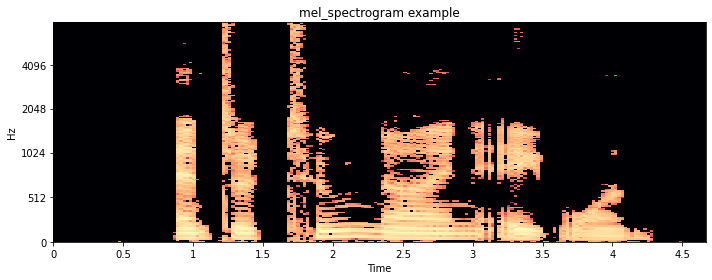

In [45]:
# lets visualized it
visualization_spectrogram(spect_example, 'mel_spectrogram example')

[-2.7046679e-04 -1.8308080e-04  4.0133193e-05 ... -1.3140017e-04
 -3.3551152e-04 -3.2280976e-04] 22050


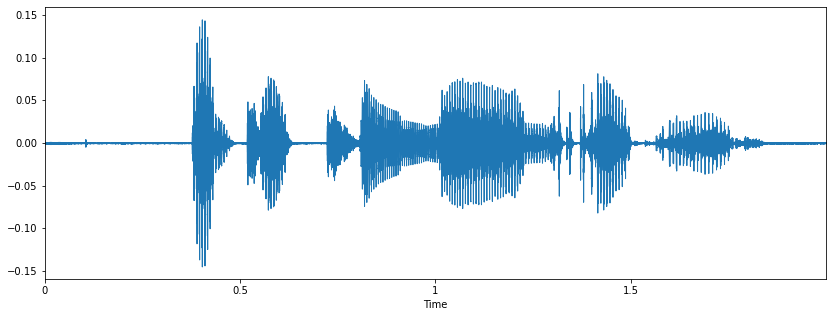

In [46]:
# let's see wave form too

import librosa
x, sr = librosa.load(audio_example_path)
print(x, sr)

plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

### Traininfg process

In [47]:
# params for training...

class Parser:
    """Parameters for training"""
    def __init__(self):
        self.lr = 3e-4
        # self.lr = 4e-4
        self.epochs = 25
        self.batch_size = 16
        self.num_workers = 1
        self.hidden_size = 1024
        self.hidden_layers = 5
        self.bidirectional = True
        self.seed = 42
        self.momentum = 0.9
        self.wd = 1e-5
        self.opt_level = 'O0'
        self.keep_batchnorm_fp32 = None
        self.loss_scale = 1
        # self.max_norm = 400
        self.max_norm = 300
        self.checkpoint_per_iteration = 0
        self.checkpoint = False
        self.save_folder = 'snapshots'
        self.best_val_model_name = "deepspeech_final.pth"
        self.save_n_recent_models = 0
        self.learning_anneal = 1.01
        self.eps = 1e-8 # for adamw
        self.betas = (0.9, 0.999) # for adamw
    
args = Parser()

### labels
tokens are alphabets and "_" and "'" and " "

In [48]:
# # labels
# labels_path = "labels.json"
# with open(labels_path) as label_file:
#     labels = json.load(label_file)

In [49]:
# labels to map token to index
labels = [
  "_",
  "'",
  "A",
  "B",
  "C",
  "D",
  "E",
  "F",
  "G",
  "H",
  "I",
  "J",
  "K",
  "L",
  "M",
  "N",
  "O",
  "P",
  "Q",
  "R",
  "S",
  "T",
  "U",
  "V",
  "W",
  "X",
  "Y",
  "Z",
  " "
]

In [50]:
# labels[:10]

In [51]:
# audio conf
audio_conf = dict(sample_rate=16000,
                  window_size=.02,
                  window_stride=.01,
                  window='hamming',
                  noise_dir=None,
                  noise_prob=0.4,
                  noise_levels=(0.0, 0.5))

In [52]:
# csv file for input wav and output text file 
train_manifest = 'data/an4_train_manifest.csv'
val_manifest = 'data/an4_val_manifest.csv'

In [53]:
# Dataset
train_dataset = SpectrogramDataset(audio_conf=audio_conf,
                                   manifest_filepath=train_manifest,
                                   labels=labels,
                                   normalize=True,
                                   speed_volume_perturb=True,
                                   spec_augment=False)
test_dataset = SpectrogramDataset(audio_conf=audio_conf,
                                  manifest_filepath=val_manifest,
                                  labels=labels,
                                  normalize=True,
                                  speed_volume_perturb=False,
                                  spec_augment=False)

In [54]:
# sampler to use bins
train_sampler = DSRandomSampler(dataset=train_dataset,
                                batch_size=args.batch_size,
                                start_index=0)

In [55]:
# data loader

train_loader = AudioDataLoader(dataset=train_dataset,
                               num_workers=args.num_workers,
                               batch_sampler=train_sampler)
test_loader = AudioDataLoader(dataset=test_dataset,
                              num_workers=args.num_workers,
                              batch_size=args.batch_size)

### model 

In [56]:
# set rnn type
rnn_type = 'lstm'

# prepare model
model = DeepSpeech(rnn_hidden_size=args.hidden_size,
                   nb_layers=args.hidden_layers,
                   labels=labels,
                   rnn_type=supported_rnns[rnn_type],
                   audio_conf=audio_conf,
                   bidirectional=args.bidirectional)

model

DeepSpeech(
  (conv): MaskConv(
    (seq_module): Sequential(
      (0): Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(20, 5))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Hardtanh(min_val=0, max_val=20, inplace=True)
      (3): Conv2d(32, 32, kernel_size=(21, 11), stride=(2, 1), padding=(10, 5))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Hardtanh(min_val=0, max_val=20, inplace=True)
    )
  )
  (rnns): Sequential(
    (0): BatchRNN(
      (rnn): LSTM(1312, 1024, bidirectional=True)
    )
    (1): BatchRNN(
      (batch_norm): SequenceWise (
      BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
      (rnn): LSTM(1024, 1024, bidirectional=True)
    )
    (2): BatchRNN(
      (batch_norm): SequenceWise (
      BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
      (rnn): LSTM(1024, 1024, bidi

In [57]:
# use TrainingState to track training state
state = TrainingState(model=model)
state.init_results_tracking(epochs=args.epochs)

In [58]:
# use greedy decoder. you can use BeamDecoder also
evaluation_decoder = GreedyDecoder(model.labels)  # Decoder used for validation

In [59]:
# device = torch.device("cpu" if args.no_cuda else "cuda")
device = torch.device("cuda")

In [62]:
# optim
model = model.to(device)
parameters = model.parameters()

In [63]:
# loss go inf if i use SGD, use AdamW

# optimizer = torch.optim.SGD(parameters,
#                             lr=args.lr,
#                             momentum=args.momentum,
#                             nesterov=True,
#                             weight_decay=args.wd)

optimizer = torch.optim.AdamW(parameters,
                              lr=args.lr,
                              betas=args.betas,
                              eps=args.eps,
                              weight_decay=args.wd)

In [64]:
# Track states for optimizer
state.track_optim_state(optimizer)

In [65]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [66]:
# use CTC for our loss
criterion = CTCLoss()
batch_time = AverageMeter()
data_time = AverageMeter()
losses = AverageMeter()

In [67]:
# check step count
len(train_loader)

39

In [68]:
# prepare check point handler
checkpoint_handler = CheckpointHandler(save_folder=args.save_folder,
                                       best_val_model_name=args.best_val_model_name,
                                       checkpoint_per_iteration=args.checkpoint_per_iteration,
                                       save_n_recent_models=args.save_n_recent_models)


### finally training loop

In [69]:
# training loop

main_proc = True

for epoch in range(state.epoch, args.epochs):
    model.train()
    end = time.time()
    start_epoch_time = time.time()
    state.set_epoch(epoch=epoch)
    train_sampler.set_epoch(epoch=epoch)
    train_sampler.reset_training_step(training_step=state.training_step)
    for idx, (data) in enumerate(train_loader, start=state.training_step):
        state.set_training_step(training_step=idx)
        inputs, targets, input_percentages, target_sizes = data
        input_sizes = input_percentages.mul_(int(inputs.size(3))).int()
        # measure data loading time
        data_time.update(time.time() - end)
        inputs = inputs.to(device)

        out, output_sizes = model(inputs, input_sizes)
        out = out.transpose(0, 1)  # TxNxH

        float_out = out.float()  # ensure float32 for loss
        loss = criterion(float_out, targets, output_sizes, target_sizes).to(device)
        loss = loss / inputs.size(0)  # average the loss by minibatch
        loss_value = loss.item()

        # Check to ensure valid loss was calculated
        valid_loss, error = check_loss(loss, loss_value)
        if valid_loss:
            optimizer.zero_grad()
            
            # compute gradient
            loss.backward()
    
            torch.nn.utils.clip_grad_norm_(parameters, args.max_norm)
            optimizer.step()
        else:
            # print(error)
            # print('Skipping grad update')
            loss_value = 0

        state.avg_loss += loss_value
        losses.update(loss_value, inputs.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if idx % 5 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                (epoch + 1), (idx + 1), len(train_loader), batch_time=batch_time, data_time=data_time, loss=losses))

        if main_proc and args.checkpoint_per_iteration:
            checkpoint_handler.save_iter_checkpoint_model(epoch=epoch, i=idx, state=state)
            
        del loss, out, float_out

    state.avg_loss /= len(train_dataset)

    epoch_time = time.time() - start_epoch_time
    print('Training Summary Epoch: [{0}]\t'
          'Time taken (s): {epoch_time:.0f}\t'
          'Average Loss {loss:.3f}\t'.format(epoch + 1, epoch_time=epoch_time, loss=state.avg_loss))

    with torch.no_grad():
        wer, cer, output_data = evaluate(test_loader=test_loader,
                                         device=device,
                                         model=model,
                                         decoder=evaluation_decoder,
                                         target_decoder=evaluation_decoder)

    state.add_results(epoch=epoch,
                      loss_result=state.avg_loss,
                      wer_result=wer,
                      cer_result=cer)

    print('Validation Summary Epoch: [{0}]\t'
          'Average WER {wer:.3f}\t'
          'Average CER {cer:.3f}\t'.format(epoch + 1, wer=wer, cer=cer))

    if main_proc and args.checkpoint:  # Save epoch checkpoint
        checkpoint_handler.save_checkpoint_model(epoch=epoch, state=state)
    # anneal lr
    for g in optimizer.param_groups:
        g['lr'] = g['lr'] / args.learning_anneal
    print('Learning rate annealed to: {lr:.6f}'.format(lr=g['lr']))

    if main_proc and (state.best_wer is None or state.best_wer > wer):
        checkpoint_handler.save_best_model(epoch=epoch, state=state)
        state.set_best_wer(wer)
        state.reset_avg_loss()
    state.reset_training_step()  # Reset training step for next epoch


Epoch: [1][1/39]	Time 1.976 (1.976)	Data 1.536 (1.536)	Loss 521.6663 (521.6663)	
Epoch: [1][6/39]	Time 1.494 (1.497)	Data 1.157 (1.141)	Loss 69.7005 (192.0656)	
Epoch: [1][11/39]	Time 1.499 (1.447)	Data 1.193 (1.121)	Loss 65.7531 (140.5103)	
Epoch: [1][16/39]	Time 1.471 (1.437)	Data 1.139 (1.120)	Loss 80.1211 (117.8095)	
Epoch: [1][21/39]	Time 1.393 (1.428)	Data 1.000 (1.119)	Loss 71.6677 (105.8230)	


KeyboardInterrupt: 

## let's evaluate the model we trained just now

In [70]:
# function to get inference

def transcribe(audio_path, spect_parser, model, decoder, device, use_half):
    spect = spect_parser.parse_audio(audio_path).contiguous()
    spect = spect.view(1, 1, spect.size(0), spect.size(1))
    spect = spect.to(device)
    if use_half:
        spect = spect.half()
    input_sizes = torch.IntTensor([spect.size(3)]).int()
    out, output_sizes = model(spect, input_sizes)
    decoded_output, decoded_offsets = decoder.decode(out, output_sizes)
    return decoded_output, decoded_offsets


In [71]:
# decode inference

def decode_results(decoded_output, decoded_offsets):
    results = {
        "output": [],
        "_meta": {
            "acoustic_model": {
                "name": os.path.basename("snapshots/deepspeech_final.pth")
            },
            "language_model": {
                "name": None,
            },
            "decoder": {
                "lm": None,
                "alpha": None,
                "beta": None,
                "type": "GreedyDecoder",
            }
        }
    }

    for b in range(len(decoded_output)):
        for pi in range(min(1, len(decoded_output[b]))):
            result = {'transcription': decoded_output[b][pi]}
            results['output'].append(result)
    return results

In [73]:
# this is sample audio 
audio_test_path = "data/an4_dataset/test/an4/wav/cen2-mjwl-b.wav"

In [75]:
# from utils import load_model
def load_model(device, model_path, use_half):
    model = DeepSpeech.load_model(model_path)
    model.eval()
    model = model.to(device)
    if use_half:
        model = model.half()
    return model

In [77]:
# load model
model = load_model("cpu", "./snapshots/deepspeech_final.pth", False)

In [78]:
decoder = GreedyDecoder(model.labels, blank_index=model.labels.index('_'))

In [79]:
spect_parser = SpectrogramParser(model.audio_conf, normalize=True)

In [80]:
decoded_output, decoded_offsets = transcribe(audio_path=audio_test_path,
                                             spect_parser=spect_parser,
                                             model=model,
                                             decoder=decoder,
                                             device="cpu",
                                             use_half=False)

In [81]:
final_result = decode_results(decoded_output, decoded_offsets)

In [82]:
final_result

{'output': [{'transcription': 'J E F F R E Y'}],
 '_meta': {'acoustic_model': {'name': 'deepspeech_final.pth'},
  'language_model': {'name': None},
  'decoder': {'lm': None,
   'alpha': None,
   'beta': None,
   'type': 'GreedyDecoder'}}}

In [83]:
IPython.display.Audio(audio_test_path)

In [84]:
! cat data/an4_dataset/test/an4/txt/cen2-mjwl-b.txt

J E F F R E Y